<a href="https://colab.research.google.com/github/TienLungSun/PyTorch-CV-NN/blob/main/SlowFast(1)%20Facebookresearch_pytorchvideo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modified from the Slow Fast provided in PyTorch Hub https://pytorch.org/hub/

*Author: FAIR PyTorchVideo* 

**SlowFast networks pretrained on the Kinetics 400 dataset**

In [ ]:
!pip install fvcore

     |████████████████████████████████| 49 kB 2.8 MB/s 
     |████████████████████████████████| 596 kB 10.3 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=afe08401ebb47619883774411b674e6f1d0c233e74a4fd9b0dfd1ac075ea1ecf
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
Successfully built fvcore
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install av

     |████████████████████████████████| 37.2 MB 106 kB/s 


In [ ]:
import torch
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)

Downloading: "https://github.com/facebookresearch/pytorchvideo/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/SLOWFAST_8x8_R50.pyth" to /root/.cache/torch/hub/checkpoints/SLOWFAST_8x8_R50.pyth


  0%|          | 0.00/264M [00:00<?, ?B/s]

In [ ]:
from typing import Dict
import json
import urllib
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
) 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The _functional_video module is deprecated. Please use the functional module instead.
  "The _functional_video module is deprecated. Please use the functional module instead."
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/_transforms_video.py:26: UserWarning: The _transforms_video module is deprecated. Please use the transforms module instead.
  "The _transforms_video module is deprecated. Please use the transforms module instead."


In [ ]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla K80


In [ ]:
model = model.eval()
model = model.to(device)

Download the id to label mapping for the Kinetics 400 dataset on which the torch hub models were trained. This will be used to get the category label names from the predicted class ids.

In [ ]:
json_url = "https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json"
json_filename = "kinetics_classnames.json"
try: urllib.URLopener().retrieve(json_url, json_filename)
except: urllib.request.urlretrieve(json_url, json_filename)

In [ ]:
with open(json_filename, "r") as f:
    kinetics_classnames = json.load(f)

# Create an id to label name mapping
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

In [ ]:
#take a look at first 10 action labels
labelLst = list(kinetics_id_to_classname.values())
print(len(labelLst), labelLst[:5])

400 ['sharpening knives', 'eating ice cream', 'cutting nails', 'changing wheel', 'bench pressing']


#### Define input transform

In [ ]:
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
slowfast_alpha = 4
num_clips = 10
num_crops = 3

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors. 
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // slowfast_alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (num_frames * sampling_rate)/frames_per_second

In [ ]:
print(num_frames, sampling_rate, frames_per_second, clip_duration)

32 2 30 2.1333333333333333


#### Upload video

輸入影像先手動處理, 只包含一個人

In [ ]:
import cv2
import imageio
import matplotlib.pyplot as plt
from IPython import display

In [ ]:
from google.colab import files
uploaded = files.upload()
fnameLst = list(uploaded.keys())
fname = fnameLst[0]
print(fname)

Saving steve.mp4 to steve.mp4
steve.mp4


In [ ]:
# get video file informaiton
cap = cv2.VideoCapture(fname)
total_frames = int(cap.get(7))
vid = imageio.get_reader(fname, 'ffmpeg')
fps = vid.get_meta_data()['fps']
__width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
__height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print('No. of frames = ', total_frames, ", w =", __width, ", h =", __height, ", fps=", fps)

No. of frames =  205 , w = 1080 , h = 1920 , fps= 29.97


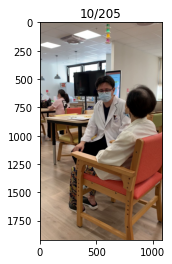

In [ ]:
# take a look at the input video
from IPython import display
import matplotlib.pyplot as plt
MaxFrame = 10
frame_count = 1
while(frame_count <= MaxFrame):
  display.clear_output(wait=True)
  plt.title(str(frame_count)+'/'+str(total_frames))
  frame = vid.get_data(frame_count)  # Capture frame-by-frame
  frame_count += 1
  plt.imshow(frame)
  plt.pause(0.1)

Load the video and transform it to the input format required by the model.

In [ ]:
# Select the duration of the clip to load by specifying the start and end duration
# The start_sec should correspond to where the action occurs in the video
start_sec = 0
end_sec = start_sec + clip_duration
print(end_sec)

2.1333333333333333


In [ ]:
# Initialize an EncodedVideo helper class and load the video
video = EncodedVideo.from_path(fname)
print(video)

In [ ]:
# Load the desired clip
video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)
print(len(video_data))

2


In [ ]:
# video data is a dictionary with "audio" and "video" keys
print(video_data['audio'].shape, video_data['video'].shape)

torch.Size([93184]) torch.Size([3, 64, 1920, 1080])


In [ ]:
# Apply a transform to normalize the video input
video_data = transform(video_data)

In [ ]:
#after transform, video_data['video'] become a [slow part tensor, fast part tensor]
print(len(video_data['video']), video_data['video'][0].shape)

2 torch.Size([3, 8, 256, 256])


In [ ]:
# Move the inputs to the desired device
inputs = video_data["video"]
inputs = [i.to(device)[None, ...] for i in inputs]

#### Get Predictions

In [ ]:
# Pass the input clip through the model
preds = model(inputs)

In [ ]:
preds.shape

torch.Size([1, 400])

In [ ]:
# Get the predicted classes
post_act = torch.nn.Softmax(dim=1)
preds = post_act(preds)
pred_classes = preds.topk(k=5).indices[0]

In [ ]:
pred_classes

tensor([287,  91,  29, 132, 373], device='cuda:0')

In [ ]:
# Map the predicted classes to the label names
pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes]
print("Top 5 predicted labels: %s" % ", ".join(pred_class_names))

Top 5 predicted labels: setting table, dining, bookbinding, folding napkins, using computer


### Model Description
SlowFast model architectures are based on [1] with pretrained weights using the 8x8 setting
on the Kinetics dataset. 

| arch | depth | frame length x sample rate | top 1 | top 5 | Flops (G) | Params (M) |
| --------------- | ----------- | ----------- | ----------- | ----------- | ----------- |  ----------- | ----------- |
| SlowFast | R50   | 8x8                        | 76.94 | 92.69 | 65.71     | 34.57      |
| SlowFast | R101  | 8x8                        | 77.90 | 93.27 | 127.20    | 62.83      |


### References
[1] Christoph Feichtenhofer et al, "SlowFast Networks for Video Recognition"
https://arxiv.org/pdf/1812.03982.pdf